In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import metrics
import torch
import torch.functional as F
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn import metrics

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import MIMIC
from lib.eval import bootstrap

# Is the clean source and target task unbiased? Yes

In [2]:
task = 'Edema'
# task = 'Cardiomegaly'
m = MIMIC(task)

317410 unknown Edema value in mimic data


In [3]:
m.df[['is_male', task]].corr()

,is_male,Edema
is_male,1.000000,-0.009445
Edema,-0.009445,1.000000


In [4]:
def MI(x, y):
    '''
    mutual information between two binary attributes
    x and y are two equal length list
    '''
    def H(p):
        return - p * np.log(p) - (1-p) * np.log(1-p)
    
    px, py = x.mean(), y.mean()
    py_x, py_notx = y[x==1].mean(), y[x==0].mean()
    return H(py) - (px * H(py_x) + (1-px) * H(py_notx)), H(px), H(py)

mi, ht, hm = MI(m.df[task], m.df['is_male'])
print(mi, ht, hm)
print(f'I({task}; male) = {mi:.2f}, I({task}; male)/H({task}) = {mi/ht:.2f}, I({task}; male)/H(male) = {mi/hm:.2f}')

4.462104700964087e-05 0.6725106982356779 0.6867981495124605
I(Edema; male) = 0.00, I(Edema; male)/H(Edema) = 0.00, I(Edema; male)/H(male) = 0.00


# Data statistics

In [68]:
n_samples = len(np.unique(m.df.subject_id))
n_males = len(np.unique(m.df[m.df.gender=='M'].subject_id))
n_females = len(np.unique(m.df[m.df.gender=='F'].subject_id))
print(f'{len(m.df)} x-rays, {len(np.unique(m.df.pt_id))} studies')
print(f'{n_samples} patients, {n_males} ({n_males/n_samples*100:.2f}%) male, {n_females} ({n_females/n_samples*100:.2f}%) female')

107510 x-rays, 62697 studies
22738 patients, 11307 (49.73%) male, 11431 (50.27%) female


In [66]:
print(f"P({task}) = {m.df[task].mean():.2f}")
print(f"P({task}|male) = {m.df[m.df.gender=='M'][task].mean():.2f}")
print(f"P({task}|female) = {m.df[m.df.gender=='F'][task].mean():.2f}")

P(Edema) = 0.60
P(Edema|male) = 0.60
P(Edema|female) = 0.61


In [55]:
m.df

,Unnamed: 0,index,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,...,Support Devices,local_path,pt_id,split,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,17,35,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50578979,train,10000935,F,52,2182,2008 - 2010,NaN
1,26,52,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,58219844,train,10000935,F,52,2182,2008 - 2010,NaN
2,27,53,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN
3,28,55,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN
4,32,62,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,54935705,train,10000980,F,73,2186,2008 - 2010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107505,425895,729287,-1.0,1.0,1.0,-1.0,1.0,0.0,-1.0,-1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,55683952,train,19998843,M,45,2187,2011 - 2013,NaN
107506,425896,729288,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN
107507,425897,729289,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN
107508,425898,729290,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN


# Threshold to Accuracy and Correlation

In [8]:
def subsample_gender(df, threshold):
    '''
    df is the mimic dataset
    remove male negative and female positive
    '''
    z = np.random.rand(len(df))
    drop = (df['gender'] == 'M') * (df[m.task] == 0) + (df['gender'] == 'F') * (df[m.task] == 1)
    drop = drop * (z <= threshold)
    new_df = df[~drop]
    return new_df
    
subsample_gender(m.df, 1)[['is_male', task]].corr()

,is_male,Edema
is_male,1.0,1.0
Edema,1.0,1.0


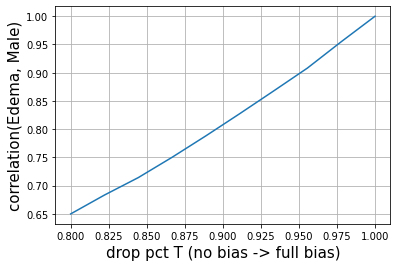

In [247]:
x = np.linspace(0.8, 1, 10)
correlation = [subsample_gender(m.df, t)[['is_male', task]].corr().iloc[0, 1] for t in x]
plt.plot(x, correlation, label=f'correlation({task}, male)')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel(f'correlation({task}, Male)', fontsize=15)
plt.grid()
# plt.legend(fontsize=15)
plt.show()

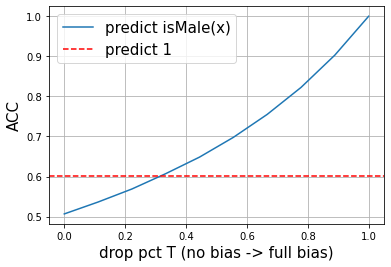

In [248]:
def ACC_male(m, t, task, f):
    '''
    accuracy of using isMale to predict task when subsampling at threshold t
    '''
    df = subsample_gender(m.df, t)
    return f(df[task], df['gender'] == 'M')

reduce_fn = metrics.accuracy_score
x = np.linspace(0, 1, 10)
acc = [ACC_male(m, t, task, reduce_fn) for t in x]
plt.plot(x, acc, label='predict isMale(x)')
plt.axhline(reduce_fn(m.df[task], np.ones_like(m.df[task])), ls='--', color='r', label='predict 1')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel('ACC', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

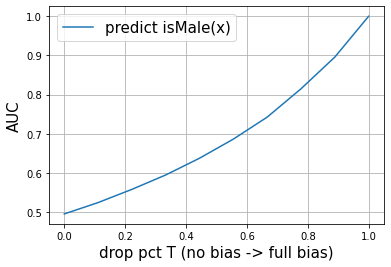

In [249]:
reduce_fn = metrics.roc_auc_score
x = np.linspace(0, 1, 10)
acc = [ACC_male(m, t, task, reduce_fn) for t in x]
plt.plot(x, acc, label='predict isMale(x)')
# plt.axhline(reduce_fn(m.df[task], np.ones_like(m.df[task])), ls='--', color='r', label='predict 1')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel('AUC', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

# Results

In [102]:
def select_list(l, *args):
    return [l[a] for a in args]

def report_latex(name, d, fmt='.1f'):
    res = [name]
    for a in d:
        l, h = get_error(a/100.0)
        res.append(f"{a:{fmt}} ({l*100:{fmt}}, {h*100:{fmt}})")

    print(" & ".join(res))

def get_error(p, n=100):
    '''bootstrap'''
    assert 0 <= p <= 1, "probablity is non-negative"
    n_test = 32 * 672 # 374
    a, b = np.percentile([sum(np.random.choice(2, n_test, p=[1-p, p])) / float(n_test) for _ in range(n)], [2.5, 97.5])
    return a, b

def plot_d_noise(d, dim=0, label=None):
    d = {k:v for k, v in d.items() if len(v) > dim}
    x = d.keys()
    y = list(map(lambda x: x[dim], d.values()))
    # plt.plot(x, y, label=label)
    # yerr = list(zip(*[get_error(a/100.0) for a in y]))
    yerr = list(zip(*[list(map(lambda i: abs(i-a/100.0) * 100, get_error(a/100.0))) for a in y]))
    # print(len(yerr), len(yerr[0]), yerr)
    plt.errorbar(x, y, yerr=yerr, label=label)

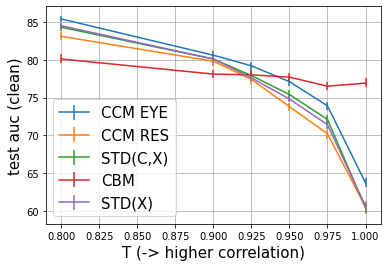

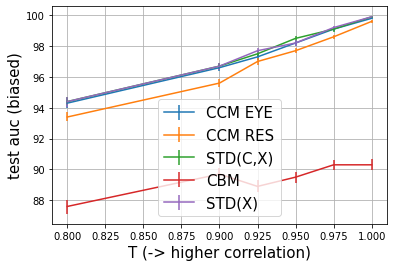

In [103]:
# key is dim_noise, value is [clean acc, t=1]
perf_dict_cbm = {
    0.8: [80.1, 87.6, 63.4],
    0.9: [78.1, 89.7, 65.9],
    0.925: [78.0, 88.9, 66.4],
    0.95: [77.7, 89.5, 67.0],
    0.975: [76.5, 90.3, 68.5],
    1.0: [76.9, 90.3, 67.3],    
}
perf_dict_alpha = { # EYE
    0.8: [85.4, 94.3],
    # 0.9: [81.3, 95.4], # 0.1
    0.9: [80.6, 96.6], # full batch [80.5, 96.4] 
    0.925: [79.2, 97.3, 83.3], # 1e-2
    # 0.925: [78.0, 97.8, 86.2], # 1e-3
    # 0.925: [77.3, 87.2, 64.6], # 1e-1
    0.95: [77.1, 98.2, 86.8], # 1e-2
    # 0.95: [74.7, 98.2, 91.2], # 1e-3
    # 0.95: [78.6, 88.8, 64.1], # 1e-1
    0.975: [73.9, 99.1, 90.4], # 1e-2
    # 0.975: [71.6, 99.2, 94.3], # 1e-3
    # 0.975: [77.7, 91.2, 68.5], # 1e-1
    1.0: [63.7, 99.8],
    # 1.0: [73.2, 94.7],    
}
perf_dict_std = { # alpha=0
    0.8: [84.3, 94.4],
    0.9: [80.1, 96.7], # small batch
    0.925: [77.9, 97.5, 86.6],
    0.95: [75.4, 98.5, 90.6],
    0.975: [72.1, 99.1, 94.1],
    1.0: [60.4, 99.9]
}
perf_dict_ccmr = {
    0.8: [83.1, 93.4],
    0.9: [79.8, 95.6],
    0.925: [77.4, 97.0, 83.5],
    0.95: [73.8, 97.7, 89.5],
    0.975: [70.2, 98.6, 92.8],
    1.0: [60.5, 99.6]
}
perf_dict_stdx = {    
    0.8: [84.5, 94.4, 76.7],
    0.9: [80.1, 96.7, 85.5],
    # 0.9: [79.8, 96.6], larger batch
    0.925: [77.6, 97.7, 87.0],
    0.95: [74.8, 98.2, 91.3],
    0.975: [71.4, 99.2, 94.8],
    1.0: [60.6, 99.9, 99.2],
}

xlabel = "T (-> higher correlation)"

plot_d_noise(perf_dict_alpha, 0, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 0, "CCM RES")
plot_d_noise(perf_dict_std, 0, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 0, "CBM")
plot_d_noise(perf_dict_stdx, 0, "STD(X)")
plt.ylabel('test auc (clean)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig('figures/clean_mimic.png')
plt.show()

plot_d_noise(perf_dict_alpha, 1, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 1, "CCM RES")
plot_d_noise(perf_dict_std, 1, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 1, "CBM")
plot_d_noise(perf_dict_stdx, 1, "STD(X)")
plt.ylabel('test auc (biased)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig('figures/bias_mimic.png')
plt.show()

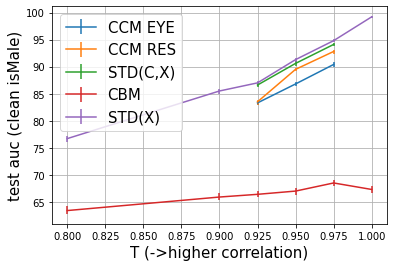

In [123]:
xlabel = "T (->higher correlation)"

plot_d_noise(perf_dict_alpha, 2, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 2, "CCM RES")
plot_d_noise(perf_dict_std, 2, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 2, "CBM")
plot_d_noise(perf_dict_stdx, 2, "STD(X)")

plt.ylabel('test auc (clean isMale)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()


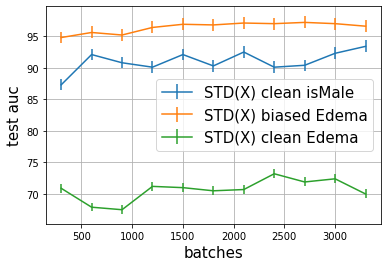

In [39]:
perf_dict_stdx = {
    300*1: [94.8, 70.9, 87.3], # save every 300 batches corresponds to outputs/standard_0.pt
    300*2: [95.6, 67.9, 92.1], # outputs/standard_1.pt
    300*3: [95.2, 67.5, 90.8],
    300*4: [96.4, 71.2, 90.1],
    300*5: [96.9, 71.0, 92.1],
    300*6: [96.8, 70.5, 90.3],
    300*7: [97.1, 70.7, 92.5],
    300*8: [97.0, 73.2, 90.1],
    300*9: [97.2, 71.9, 90.4],
    300*10: [97.0, 72.4, 92.3],
    300*11: [96.6, 70.0, 93.4]
}

xlabel = "batches"

plot_d_noise(perf_dict_stdx, 2, "STD(X) clean isMale")
plot_d_noise(perf_dict_stdx, 0, "STD(X) biased Edema")
plot_d_noise(perf_dict_stdx, 1, "STD(X) clean Edema")
plt.ylabel('test auc', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()


# Per group investigation (automated)

In [109]:
from collections import defaultdict
methods = ['CCM EYE', 'CCM RES', 'STD(C,X)', 'CBM', 'STD(X)']
results = {m: defaultdict(dict) for m in methods} # results[method][x][key]

def get_approach_name(fn, alpha):
    name = fn.split('/')[-1].split('_')[0]
    if name == 'ccm' and alpha != 0:
        return methods[0]    
    elif name == 'ccmr':
        return methods[1]
    elif name == 'ccm' and alpha == 0:
        return methods[2]
    elif name == 'cbm':
        return methods[3]
    elif name == 'standard':
        return methods[4]    
    else:
        raise Exception(f"not defined name {name}")

In [120]:
filenames = [ # name, t, alpha
    # # t = 0.975
    # ('../outputs/21412056620911ec830e8fa97a4e8129/ccmr_Edema.npz', 0.975, None),
    # ('../outputs/7e53e8f661b311ec830e8fa97a4e8129/ccm_Edema.npz', 0.975, 0),
    # ('../outputs/c9a321f261ac11ec830e8fa97a4e8129/ccm_Edema.npz', 0.975, 1e-2),
    # ('../outputs/cfa9fff0617811ec830e8fa97a4e8129/cbm_Edema.npz', 0.975, None),
    # ('../outputs/ed0b99ba614f11ec830e8fa97a4e8129/standard_Edema.npz', 0.975, None),    
    # # t = 0.95
    # ('../outputs/a67cb9785f0811ec830e8fa97a4e8129/standard_Edema.npz', 0.95, None),
    # ('../outputs/579ec276620311ec830e8fa97a4e8129/ccmr_Edema.npz', 0.95, None),
    # ('../outputs/4643a8d2616a11ec830e8fa97a4e8129/cbm_Edema.npz', 0.95, None),
    # ('../outputs/fc58903e616911ec830e8fa97a4e8129/ccm_Edema.npz', 0.95, 0),
    # ('../outputs/86ccb66a616411ec830e8fa97a4e8129/ccm_Edema.npz', 0.95, 1e-2),
    # # t = 0.925
    # ('../outputs/7fcfa8a661fd11ec830e8fa97a4e8129/ccmr_Edema.npz', 0.925, None),
    # ('../outputs/c0c1a2da618d11ec830e8fa97a4e8129/ccm_Edema.npz', 0.925, 0),
    # ('../outputs/342e322a618311ec830e8fa97a4e8129/ccm_Edema.npz', 0.925, 1e-2),
    # ('../outputs/d35ee6be615b11ec830e8fa97a4e8129/cbm_Edema.npz', 0.925, None),
    # ('../outputs/601c7e16614511ec830e8fa97a4e8129/standard_Edema.npz', 0.925, None),
    # # t = 0.9
    # ('../outputs/7b0a1aac4b6111ecb773ac1f6b24a434/ccm_Edema.npz', 0.9, 0.01),
    # ('../outputs/5a4ce99a4b3711ecb773ac1f6b24a434/standard_Edema.npz', 0.9, None),
    # ('../outputs/5df7a9fe4b3711ecb773ac1f6b24a434/cbm_Edema.npz', 0.9, None),
    # ('../outputs/36dbcf544bf911ecb773ac1f6b24a434/ccm_Edema.npz', 0.9, 0),
    # ('../outputs/4e5eb1be4bdb11ecb773ac1f6b24a434/ccmr_Edema.npz', 0.9, None),
    # # t = 0.8
    ('../outputs/86698a8046bc11ecb773ac1f6b24a434/ccm_Edema.npz', 0.8, 0),
    ('../outputs/404868d246bc11ecb773ac1f6b24a434/ccm_Edema.npz', 0.8, 0.01),
    ('../outputs/3f45f33446ba11ecb773ac1f6b24a434/ccmr_Edema.npz', 0.8, None),
    ('../outputs/f77275b2425611ecb773ac1f6b24a434/standard_Edema.npz', 0.8, None),
    ('../outputs/80b3060c420211ecb773ac1f6b24a434/cbm_Edema.npz', 0.8, None),
]

for fn, t, alpha in filenames:
    task = fn.split('/')[-1].split('_')[-1].split('.')[0]
    method_name = get_approach_name(fn, alpha)
    output = torch.load(fn)
    m = MIMIC(task)
    m.df['output'] = softmax(output, 1)[:, 1]
        
    # extract test files (todo: change to cases w/o training data)
    indices = list(range(len(m)))
    labels = list(m.df[task])
    _, test_indices = train_test_split(indices, stratify=labels, random_state=42)
    m_test = m.df.iloc[test_indices]
    
    # gather result (todo: vary for other purposes)
    metric = metrics.roc_auc_score
    y, yhat = m_test[task], m_test['output']
    l, r = bootstrap(metric, y, yhat)
    results[method_name][t]['clean'] = [l, metric(y, yhat), r]
    
    m_sub = subsample_gender(m_test, t)
    y, yhat = m_sub[task], m_sub['output']
    l, r = bootstrap(metric, y, yhat)
    results[method_name][t]['biased'] = [l, metric(y, yhat), r]

317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data


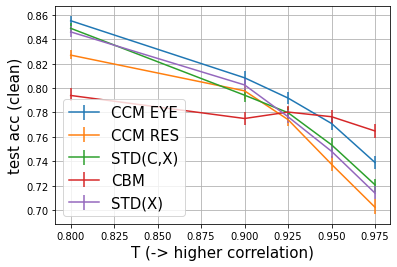

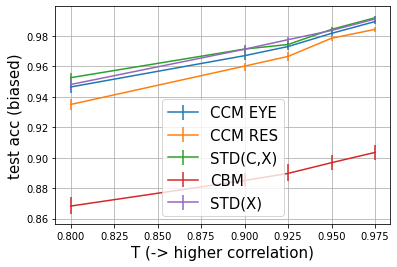

In [121]:
# plot result
def plot_results(results, method_name, key):
    x = sorted(results[method_name].keys())
    values = np.array([results[method_name][x_][key] for x_ in x]) # (n, 3)
    y = values[:, 1]
    yerr = np.vstack([y - values[:, 0], values[:, 2] - y])
    plt.errorbar(x, y, yerr=yerr, label=method_name)
        
xlabel = "T (-> higher correlation)"
key = 'clean'
plot_results(results, 'CCM EYE', key)
plot_results(results, 'CCM RES', key)
plot_results(results, 'STD(C,X)', key)
plot_results(results, 'CBM', key)
plot_results(results, 'STD(X)', key)
plt.ylabel(f'test acc ({key})', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

xlabel = "T (-> higher correlation)"
key = 'biased'
plot_results(results, 'CCM EYE', key)
plot_results(results, 'CCM RES', key)
plot_results(results, 'STD(C,X)', key)
plot_results(results, 'CBM', key)
plot_results(results, 'STD(X)', key)
plt.ylabel(f'test acc ({key})', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()


# Per group investigation

In [89]:
# t = 0.975
# fn = '../outputs/21412056620911ec830e8fa97a4e8129/ccmr_Edema.npz'
# fn = '../outputs/bc5311c261c711ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-3
# fn = '../outputs/f296344c61ba11ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-1
# fn = '../outputs/7e53e8f661b311ec830e8fa97a4e8129/ccm_Edema.npz' # 0
# fn = '../outputs/c9a321f261ac11ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-2
# fn = '../outputs/cfa9fff0617811ec830e8fa97a4e8129/cbm_Edema.npz'
# fn = '../outputs/ed0b99ba614f11ec830e8fa97a4e8129/standard_Edema.npz'

# t = 0.95
# fn = '../outputs/a67cb9785f0811ec830e8fa97a4e8129/standard_Edema.npz'
# fn = '../outputs/579ec276620311ec830e8fa97a4e8129/ccmr_Edema.npz'
# fn = '../outputs/f1bb5a7c617c11ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-3
# fn = '../outputs/77873152616f11ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-1
# fn = '../outputs/4643a8d2616a11ec830e8fa97a4e8129/cbm_Edema.npz'
# fn = '../outputs/fc58903e616911ec830e8fa97a4e8129/ccm_Edema.npz' # 0
# fn = '../outputs/86ccb66a616411ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-2

# t = 0.925
# fn = '../outputs/7fcfa8a661fd11ec830e8fa97a4e8129/ccmr_Edema.npz'
# fn = '../outputs/096f3fe661a311ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-3
# fn = '../outputs/076d6aca619811ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-1
# fn = '../outputs/c0c1a2da618d11ec830e8fa97a4e8129/ccm_Edema.npz' # 0
# fn = '../outputs/342e322a618311ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-2
# fn = '../outputs/d35ee6be615b11ec830e8fa97a4e8129/cbm_Edema.npz'
# fn = '../outputs/601c7e16614511ec830e8fa97a4e8129/standard_Edema.npz'

t=0.9
# fn = '../outputs/7b0a1aac4b6111ecb773ac1f6b24a434/ccm_Edema.npz'
# fn = '../outputs/5a4ce99a4b3711ecb773ac1f6b24a434/standard_Edema.npz'
fn = '../outputs/5df7a9fe4b3711ecb773ac1f6b24a434/cbm_Edema.npz'

task = fn.split('/')[-1].split('_')[-1].split('.')[0]
output = torch.load(fn)
m = MIMIC(task)
print(output.shape) # 200 is a mistake but it shouldn't change the result in any way
m.df['output'] = softmax(output, 1)[:, 1]

317410 unknown Edema value in mimic data
(107510, 2)


In [90]:
indices = list(range(len(m)))
labels = list(m.df[task])
_, test_indices = train_test_split(indices, stratify=labels, random_state=42)
m_test = m.df.iloc[test_indices]
m_test[[task, 'is_male', 'output']].mean()

Edema      0.601235
is_male    0.553836
output     0.606245
dtype: float64

In [91]:
metric = metrics.roc_auc_score
y, yhat = m_test[task], m_test['output']
print(f'AUC {task} (clean):', metric(y, yhat), bootstrap(metric, y, yhat))

m_sub = subsample_gender(m_test, t)
y, yhat = m_sub[task], m_sub['output']
print(f'AUC {task} T={t}:', metric(y, yhat), bootstrap(metric, y, yhat))

y, yhat = m_test['is_male'], m_test['output']
print(f'AUC is_male:', metric(y, yhat), bootstrap(metric, y, yhat))

AUC Edema (clean): 0.7764832403479665 (0.7718087853882387, 0.7827185689356541)
AUC Edema T=0.925: 0.9772534013605442 (0.9752522553457239, 0.9796160430898232)
AUC is_male: 0.8698020062548752 (0.8658867229113972, 0.873764925801104)


In [92]:
print('average softmax prediction Male   Edema=1: {:.2f}'.format(m_test[(m_test['is_male']==1) * (m_test[task]==1)]['output'].mean()))
print('average softmax prediction Male   Edema=0: {:.2f}'.format(m_test[(m_test['is_male']==1) * (m_test[task]==0)]['output'].mean()))
print('average softmax prediction Female Edema=1: {:.2f}'.format(m_test[(m_test['is_male']==0) * (m_test[task]==1)]['output'].mean()))
print('average softmax prediction Female Edema=0: {:.2f}'.format(m_test[(m_test['is_male']==0) * (m_test[task]==0)]['output'].mean()))

average softmax prediction Male   Edema=1: 0.96
average softmax prediction Male   Edema=0: 0.65
average softmax prediction Female Edema=1: 0.48
average softmax prediction Female Edema=0: 0.08


In [93]:
mp = lambda m: m[(m['is_male']==1) * (m[task]==1)]
mn = lambda m: m[(m['is_male']==1) * (m[task]==0)]
fp = lambda m: m[(m['is_male']==0) * (m[task]==1)]
fn = lambda m: m[(m['is_male']==0) * (m[task]==0)]

y, yhat = mp(m_test)[task], mp(m_test)['output']
a_ = (y == (yhat > 0.5)).mean()
print(f'ACC {task} (clean) for male positive:', a_)

y, yhat = mn(m_test)[task], mn(m_test)['output']
b_ = (y == (yhat > 0.5)).mean()
print(f'ACC {task} (clean) for male negative:', b_)

y, yhat = fp(m_test)[task], fp(m_test)['output']
c_ = (y == (yhat > 0.5)).mean()
print(f'ACC {task} (clean) for female positive:', c_)

y, yhat = fn(m_test)[task], fn(m_test)['output']
d_ = (y == (yhat > 0.5)).mean()
print(f'ACC {task} (clean) for female negative:', d_)

print(f'ACC {task} (clean) for MP, MN, FP, FN are {t}: [{a_*100:.1f}, {b_*100:.1f}, {c_*100:.1f}, {d_*100:.1f}],')

ACC Edema (clean) for male positive: 0.9876112174794459
ACC Edema (clean) for male negative: 0.31163642417179954
ACC Edema (clean) for female positive: 0.47232523005081717
ACC Edema (clean) for female negative: 0.9622160900021227
ACC Edema (clean) for MP, MN, FP, FN are 0.925: [98.8, 31.2, 47.2, 96.2],


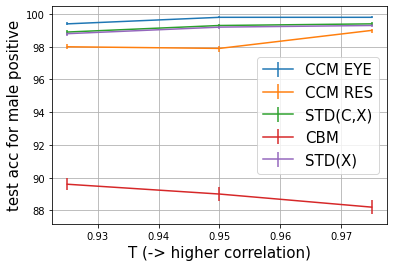

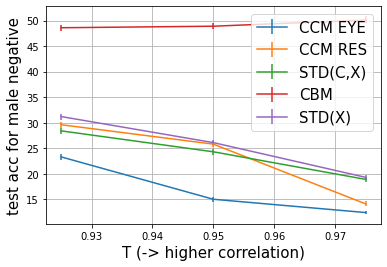

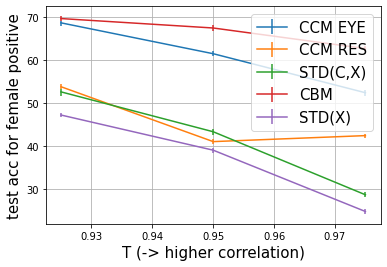

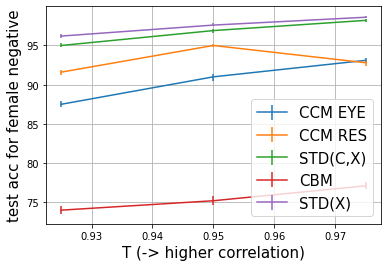

In [94]:
# key is T, value is [MP, MN, FP, FN]
perf_dict_cbm = {
    0.975: [88.2, 50.1, 62.7, 77.1],
    0.95: [89.0, 48.9, 67.5, 75.2],
    0.925: [89.6, 48.6, 69.7, 74.0],
}
perf_dict_alpha = { # EYE
    0.975: [99.8, 12.4, 52.4, 93.1], # 1e-2
    0.95: [99.8, 15.0, 61.5, 91.0], # 1e-2
    0.925: [99.4, 23.3, 68.7, 87.5], # 1e-2
}
perf_dict_std = { # alpha=0
    0.975: [99.4, 18.9, 28.6, 98.2],
    0.95: [99.3, 24.3, 43.3, 96.9],
    0.925: [98.9, 28.4, 52.6, 95.0],
}
perf_dict_ccmr = {
    0.975: [99.0, 14.1, 42.4, 92.8],
    0.95: [97.9, 25.8, 41.0, 95.0],
    0.925: [98.0, 29.6, 53.8, 91.6],
}
perf_dict_stdx = {    
    0.975: [99.3, 19.3, 24.7, 98.6],
    0.95: [99.2, 26.1, 39.0, 97.6],
    0.925: [98.8, 31.2, 47.2, 96.2],
}

xlabel = "T (-> higher correlation)"

for i, v in enumerate(['male positive', 'male negative', 'female positive', 'female negative']):
    plot_d_noise(perf_dict_alpha, i, "CCM EYE")
    plot_d_noise(perf_dict_ccmr, i, "CCM RES")
    plot_d_noise(perf_dict_std, i, "STD(C,X)")
    plot_d_noise(perf_dict_cbm, i, "CBM")
    plot_d_noise(perf_dict_stdx, i, "STD(X)")
    plt.ylabel(f'test acc for {v}', fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

# Others

In [12]:
y, yhat = m_test[task], m_test['output']
print(f'ACC {task} (clean):', (y == (yhat > 0.5)).mean())

y, yhat = m_test['is_male'], m_test['output']
print(f'ACC is_male:', (y == (yhat > 0.5)).mean())

y, yhat = m_test[m_test['is_male']==1][task], m_test[m_test['is_male']==1]['output']
print(f'ACC {task} for male:', (y == (yhat > 0.5)).mean())

y, yhat = m_test[m_test['is_male']==0][task], m_test[m_test['is_male']==0]['output']
print(f'ACC {task} for female:', (y == (yhat > 0.5)).mean())

ACC Edema (clean): 0.610536498251358
ACC is_male: 0.8851104992931021
ACC Edema for male: 0.6698239957006583
ACC Edema for female: 0.5369412941961308


In [199]:
metrics.roc_auc_score(m_test['is_male'], m_test['output'])

0.8368912804469851

In [200]:
q0, q1, q2, q3 = np.percentile(m_test['output'], [0, 25, 50, 75])

In [201]:
m_test[(m_test['output'] >= q0) * (m_test['output'] <= q1)][[task, 'is_male', 'output']].mean()

Edema      0.247917
is_male    0.168304
output     0.047949
dtype: float64

In [202]:
m_test[(m_test['output'] >= q1) * (m_test['output'] <= q2)][[task, 'is_male', 'output']].mean()

Edema      0.532222
is_male    0.440839
output     0.462149
dtype: float64

In [203]:
m_test[(m_test['output'] >= q2) * (m_test['output'] <= q3)][[task, 'is_male', 'output']].mean()

Edema      0.717220
is_male    0.688942
output     0.917055
dtype: float64

In [204]:
m_test[(m_test['output'] >= q3)][[task, 'is_male', 'output']].mean()

Edema      0.907589
is_male    0.917262
output     0.995925
dtype: float64

In [232]:
mi, ht, hm = MI(m_test[task], m_test['is_male'])
print(f'I({task}; male) = {mi:.2f}, I({task}; male)/H({task}) = {mi/ht:.2f}, I({task}; male)/H(male) = {mi/hm:.2f}')
m_test[['is_male', task]].corr()

I(Edema; male) = 0.00, I(Edema; male)/H(Edema) = 0.00, I(Edema; male)/H(male) = 0.00


,is_male,Edema
is_male,1.000000,-0.010851
Edema,-0.010851,1.000000
